# Import Libraries

In [0]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from torchsummary import summary
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                        transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-6.0,6.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                        #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
class Net(nn.Module):
    def __init__(self):
        """ This function instantiates all the model layers """
        super(Net, self).__init__()

        dropout_rate = 0.1

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 28x28x1 | Output: 26x26x8 | RF: 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 26x26x8 | Output: 24x24x8 | RF: 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 24x24x8 | Output: 22x22x16 | RF: 7x7

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 22x22x16 | Output: 20x20x16 | RF: 9x9

        self.pool = nn.MaxPool2d(2, 2)  # Input: 20x20x16 | Output: 10x10x16 | RF: 10x10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 10x10x16 | Output: 8x8x16 | RF: 14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 8x8x16 | Output: 6x6x16 | RF: 18x18

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_rate)
        )  # Input: 6x6x16 | Output: 6x6x10 | RF: 18x18

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  # Input: 6x6x10 | Output: 1x1x10 | RF: 28x28
    
    def forward(self, x):
        
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# The model


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,168
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
           Conv2d-13           [-1, 16, 20, 20]           2,320
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

Without Regularization L1, L2

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

train_losses_L1 = []
test_losses_L1 = []
train_acc_L1 = []
test_acc_L1 = []

train_losses_L2 = []
test_losses_L2 = []
train_acc_L2 = []
test_acc_L2 = []

train_losses_L1_L2 = []
test_losses_L1_L2 = []
train_acc_L1_L2 = []
test_acc_L1_L2 = []

def train(model, device, train_loader, optimizer, epoch, loss_type):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if loss_type == 'NO_L1_L2':
      train_losses.append(loss)

    elif loss_type == 'L1':
      l1_crit = torch.nn.L1Loss(size_average=False)
      reg_loss=0
      for param in model.parameters():
        reg_loss += torch.sum(abs(param))
        
        #zero_vector = torch.rand_like(param)*0
        #reg_loss += l1_crit(param, zero_vector)
      factor = 0.0005
      loss += factor*reg_loss
      train_losses_L1.append(loss)
    
    elif loss_type == 'L2':
      train_losses_L2.append(loss) 

    elif loss_type == 'L1_L2':
      l1_crit = torch.nn.L1Loss(size_average=False)      
      reg_loss=0
      for param in model.parameters():
        reg_loss += torch.sum(abs(param))     
        #zero_vector = torch.rand_like(param)*0
        #reg_loss += l1_crit(param, zero_vector)
      factor = 0.0005
      loss += factor*reg_loss
      train_losses.append(loss)
     
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    if loss_type == 'NO_L1_L2':
      train_acc.append(100*correct/processed)
    elif loss_type == 'L1':
      train_acc_L1.append(100*correct/processed)
    elif loss_type == 'L2':
      train_acc_L2.append(100*correct/processed)
    elif loss_type == 'ElastiNet':
      train_acc_L1_L2.append(100*correct/processed)

def test(model, device, test_loader,loss_type):
    model.eval()
    test_loss = 0
    correct=0
    
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
       
    test_loss /= len(test_loader.dataset)

    if loss_type == 'NO_L1_L2':
      test_losses.append(test_loss)
    elif loss_type == 'L1':
      test_losses_L1.append(test_loss)
    elif loss_type == 'L2':
      test_losses_L2.append(test_loss)
    elif loss_type == 'L1_L2':
      test_losses_L1_L2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    if loss_type == 'NO_L1_L2':
      test_acc.append(100. * correct / len(test_loader.dataset))
    elif loss_type == 'L1':
      test_acc_L1.append(100. * correct / len(test_loader.dataset))
    elif loss_type == 'L2':
      test_acc_L2.append(100. * correct / len(test_loader.dataset))
    elif loss_type == 'L1_L2':
      test_acc_L1_L2.append(100. * correct / len(test_loader.dataset))

    

# Let's Train and test our model

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,'NO_L1_L2')
    # scheduler.step()
    test(model, device, test_loader,'NO_L1_L2')


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.196894109249115 Batch_id=468 Accuracy=88.32: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1962, Accuracy: 9532/10000 (95.32%)

EPOCH: 1


Loss=0.18897534906864166 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:15<00:00, 31.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1185, Accuracy: 9678/10000 (96.78%)

EPOCH: 2


Loss=0.06622933596372604 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:14<00:00, 39.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0839, Accuracy: 9781/10000 (97.81%)

EPOCH: 3


Loss=0.05734336003661156 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0857, Accuracy: 9748/10000 (97.48%)

EPOCH: 4


Loss=0.11545389890670776 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9797/10000 (97.97%)

EPOCH: 5


Loss=0.04529239609837532 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9849/10000 (98.49%)

EPOCH: 6


Loss=0.05531248450279236 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:14<00:00, 31.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9827/10000 (98.27%)

EPOCH: 7


Loss=0.12432660907506943 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9859/10000 (98.59%)

EPOCH: 8


Loss=0.03506363555788994 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9834/10000 (98.34%)

EPOCH: 9


Loss=0.0816425010561943 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9875/10000 (98.75%)

EPOCH: 10


Loss=0.060102540999650955 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 31.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9881/10000 (98.81%)

EPOCH: 11


Loss=0.036733951419591904 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9876/10000 (98.76%)

EPOCH: 12


Loss=0.010706561617553234 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 31.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9900/10000 (99.00%)

EPOCH: 13


Loss=0.01596701145172119 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 31.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9880/10000 (98.80%)

EPOCH: 14


Loss=0.14699889719486237 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 36.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9890/10000 (98.90%)

EPOCH: 15


Loss=0.023294376209378242 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:15<00:00, 31.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9900/10000 (99.00%)

EPOCH: 16


Loss=0.016804346814751625 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9904/10000 (99.04%)

EPOCH: 17


Loss=0.01874547451734543 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9889/10000 (98.89%)

EPOCH: 18


Loss=0.04388509318232536 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9900/10000 (99.00%)

EPOCH: 19


Loss=0.022936001420021057 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 31.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9922/10000 (99.22%)

EPOCH: 20


Loss=0.042199522256851196 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9916/10000 (99.16%)

EPOCH: 21


Loss=0.033641327172517776 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9910/10000 (99.10%)

EPOCH: 22


Loss=0.019948402419686317 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9918/10000 (99.18%)

EPOCH: 23


Loss=0.009418810717761517 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 30.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9910/10000 (99.10%)

EPOCH: 24


Loss=0.03625430539250374 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9912/10000 (99.12%)

EPOCH: 25


Loss=0.01897723414003849 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9917/10000 (99.17%)

EPOCH: 26


Loss=0.10410815477371216 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9919/10000 (99.19%)

EPOCH: 27


Loss=0.016340618953108788 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9929/10000 (99.29%)

EPOCH: 28


Loss=0.01587904989719391 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 31.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9923/10000 (99.23%)

EPOCH: 29


Loss=0.025045320391654968 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9920/10000 (99.20%)

EPOCH: 30


Loss=0.012191456742584705 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 30.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9925/10000 (99.25%)

EPOCH: 31


Loss=0.08452761918306351 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 37.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9931/10000 (99.31%)

EPOCH: 32


Loss=0.043710578233003616 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9931/10000 (99.31%)

EPOCH: 33


Loss=0.032532863318920135 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 34


Loss=0.013481572270393372 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9915/10000 (99.15%)

EPOCH: 35


Loss=0.0130526227876544 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9924/10000 (99.24%)

EPOCH: 36


Loss=0.0330280177295208 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9915/10000 (99.15%)

EPOCH: 37


Loss=0.04219701513648033 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9922/10000 (99.22%)

EPOCH: 38


Loss=0.00394478440284729 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9914/10000 (99.14%)

EPOCH: 39


Loss=0.021918194368481636 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]



Test set: Average loss: 0.0258, Accuracy: 9928/10000 (99.28%)



# **No _L1_L2 Model RF **

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


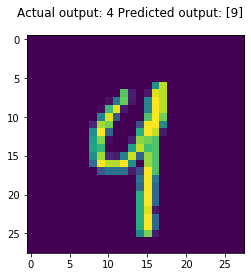

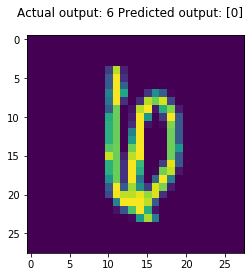

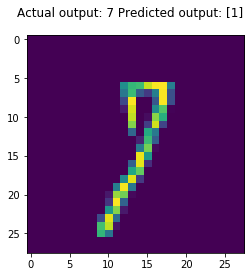

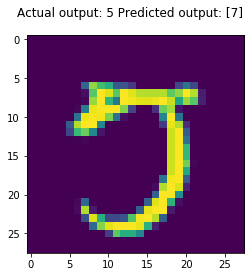

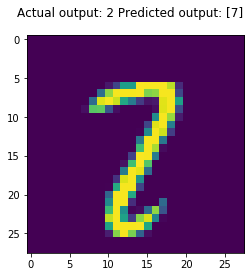

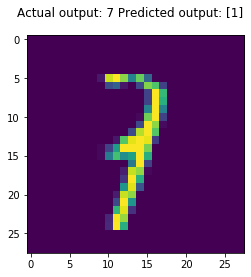

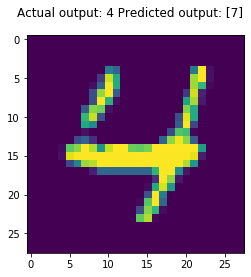

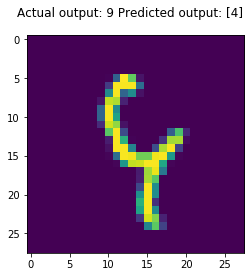

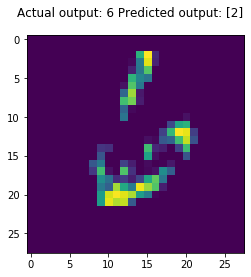

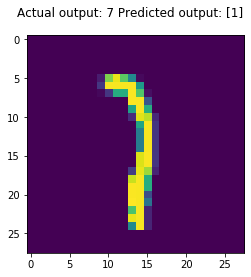

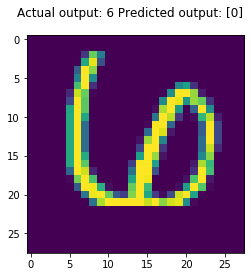

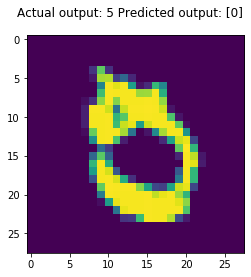

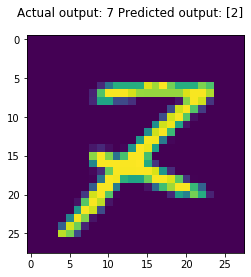

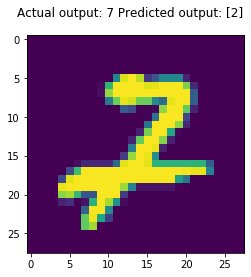

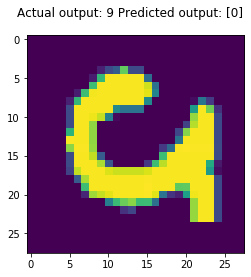

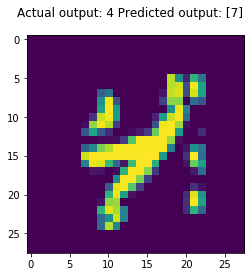

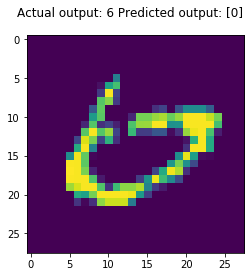

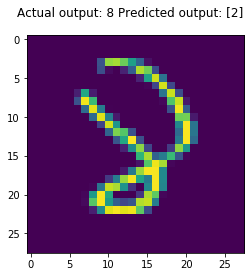

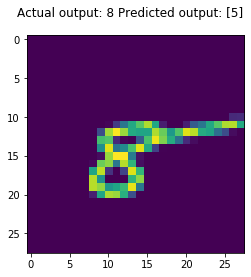

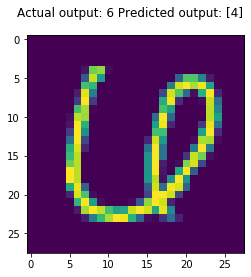

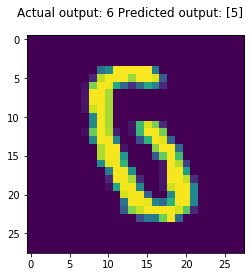

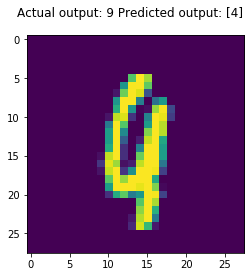

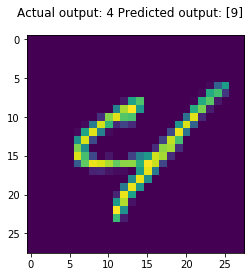

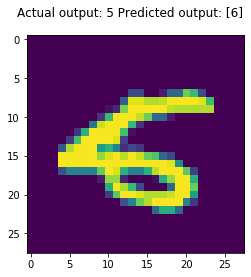

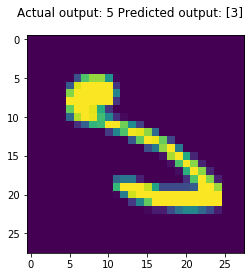

In [0]:
import numpy as np
import matplotlib.pyplot as plt

with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count==25:
                  break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " Predicted output: " + str(predx[i]))
                #fig.savefig(str(count)+".jpg")
                #files.download(str(count)+".jpg")
                count = count+1


## No _L1_L2 Model PLOTTING 

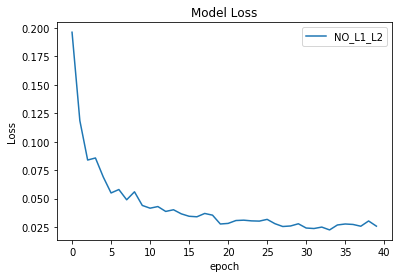

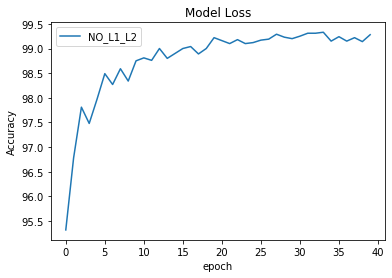

In [0]:
plt.plot(test_losses)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['NO_L1_L2'],loc='best')
plt.show()

plt.plot(test_acc)
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['NO_L1_L2'],loc='best')
plt.show()

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,'L1')
    # scheduler.step()
    test(model, device, test_loader,'L1')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.3693017363548279 Batch_id=468 Accuracy=88.03: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1394, Accuracy: 9698/10000 (96.98%)

EPOCH: 1


Loss=0.2822391092777252 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:16<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0974, Accuracy: 9770/10000 (97.70%)

EPOCH: 2


Loss=0.24954301118850708 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0894, Accuracy: 9774/10000 (97.74%)

EPOCH: 3


Loss=0.2694370150566101 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:16<00:00, 35.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9858/10000 (98.58%)

EPOCH: 4


Loss=0.20753972232341766 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:16<00:00, 28.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9863/10000 (98.63%)

EPOCH: 5


Loss=0.19421733915805817 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 28.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9870/10000 (98.70%)

EPOCH: 6


Loss=0.3403165638446808 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:16<00:00, 35.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0553, Accuracy: 9848/10000 (98.48%)

EPOCH: 7


Loss=0.29743391275405884 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0590, Accuracy: 9843/10000 (98.43%)

EPOCH: 8


Loss=0.19868724048137665 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:16<00:00, 28.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9834/10000 (98.34%)

EPOCH: 9


Loss=0.17226506769657135 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9859/10000 (98.59%)

EPOCH: 10


Loss=0.23717078566551208 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0642, Accuracy: 9818/10000 (98.18%)

EPOCH: 11


Loss=0.20730292797088623 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9841/10000 (98.41%)

EPOCH: 12


Loss=0.17615774273872375 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:16<00:00, 28.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9787/10000 (97.87%)

EPOCH: 13


Loss=0.19012200832366943 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9864/10000 (98.64%)

EPOCH: 14


Loss=0.18516387045383453 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9881/10000 (98.81%)

EPOCH: 15


Loss=0.22754329442977905 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9846/10000 (98.46%)

EPOCH: 16


Loss=0.21976593136787415 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9892/10000 (98.92%)

EPOCH: 17


Loss=0.22051489353179932 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9835/10000 (98.35%)

EPOCH: 18


Loss=0.24325759708881378 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9862/10000 (98.62%)

EPOCH: 19


Loss=0.21394053101539612 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9833/10000 (98.33%)

EPOCH: 20


Loss=0.20449933409690857 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:16<00:00, 28.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9863/10000 (98.63%)

EPOCH: 21


Loss=0.221394345164299 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9855/10000 (98.55%)

EPOCH: 22


Loss=0.19802862405776978 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9869/10000 (98.69%)

EPOCH: 23


Loss=0.18301168084144592 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9879/10000 (98.79%)

EPOCH: 24


Loss=0.20901820063591003 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:16<00:00, 28.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9856/10000 (98.56%)

EPOCH: 25


Loss=0.19228170812129974 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9861/10000 (98.61%)

EPOCH: 26


Loss=0.25184738636016846 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:16<00:00, 28.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9855/10000 (98.55%)

EPOCH: 27


Loss=0.23132221400737762 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9856/10000 (98.56%)

EPOCH: 28


Loss=0.1722344309091568 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:16<00:00, 28.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9843/10000 (98.43%)

EPOCH: 29


Loss=0.1816517412662506 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:16<00:00, 28.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0561, Accuracy: 9846/10000 (98.46%)

EPOCH: 30


Loss=0.24210843443870544 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0621, Accuracy: 9810/10000 (98.10%)

EPOCH: 31


Loss=0.1910390853881836 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9861/10000 (98.61%)

EPOCH: 32


Loss=0.18444234132766724 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:16<00:00, 28.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9848/10000 (98.48%)

EPOCH: 33


Loss=0.1606472134590149 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:16<00:00, 27.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9872/10000 (98.72%)

EPOCH: 34


Loss=0.14666274189949036 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:16<00:00, 28.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9844/10000 (98.44%)

EPOCH: 35


Loss=0.19789934158325195 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:16<00:00, 28.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9874/10000 (98.74%)

EPOCH: 36


Loss=0.20146684348583221 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0682, Accuracy: 9799/10000 (97.99%)

EPOCH: 37


Loss=0.2172294557094574 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0862, Accuracy: 9750/10000 (97.50%)

EPOCH: 38


Loss=0.19030728936195374 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9852/10000 (98.52%)

EPOCH: 39


Loss=0.16826443374156952 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:16<00:00, 28.41it/s]



Test set: Average loss: 0.0452, Accuracy: 9872/10000 (98.72%)



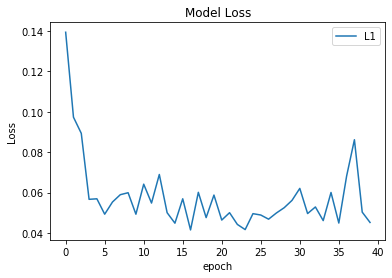

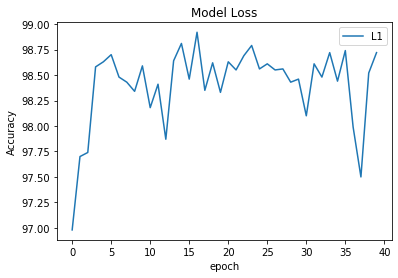

In [0]:
plt.plot(test_losses_L1)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['L1'],loc='best')
plt.show()

plt.plot(test_acc_L1)
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['L1'],loc='best')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


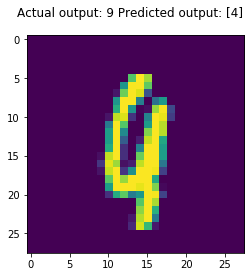

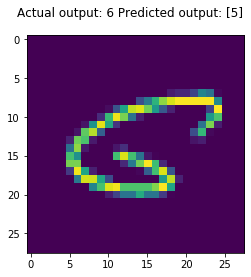

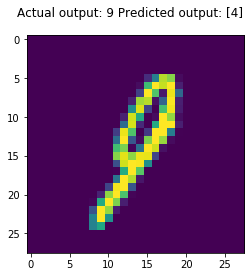

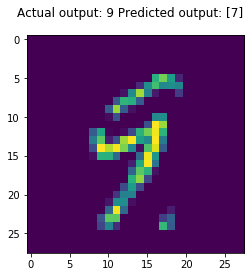

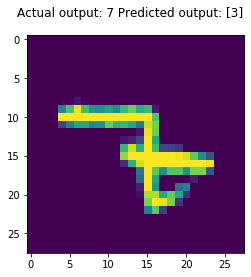

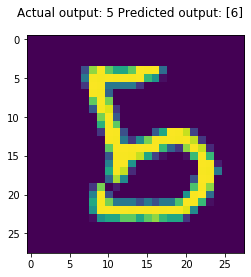

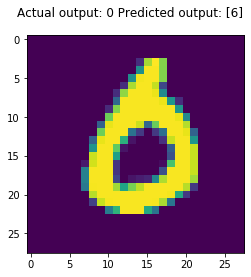

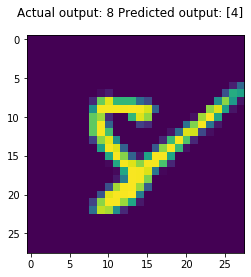

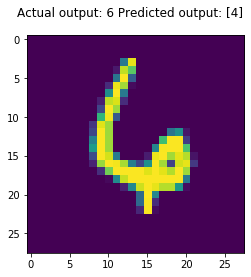

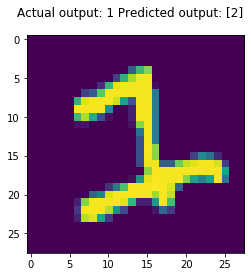

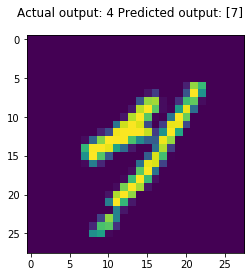

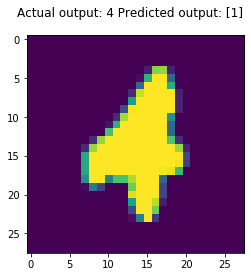

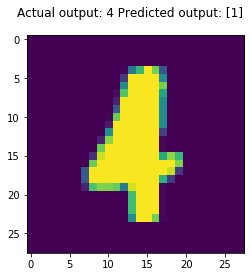

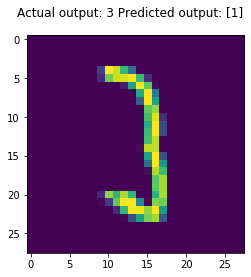

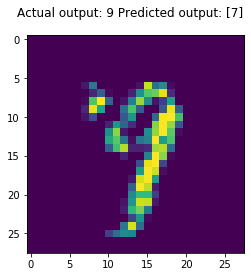

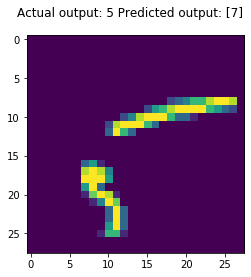

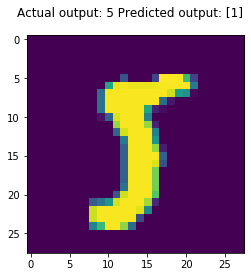

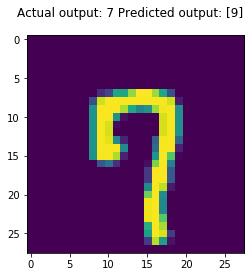

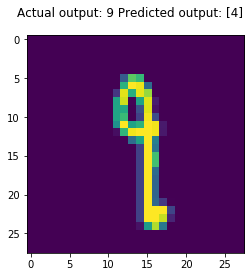

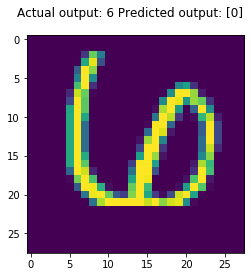

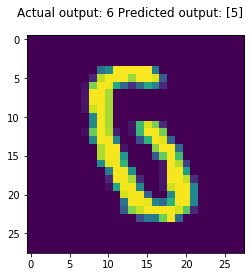

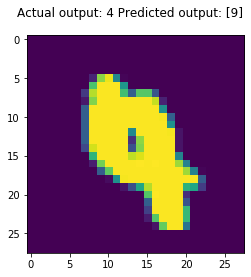

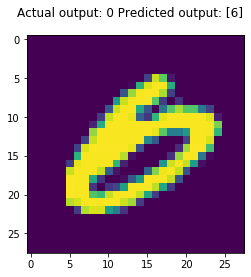

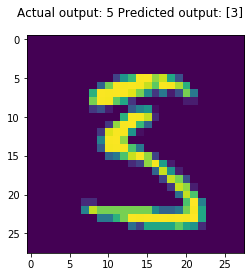

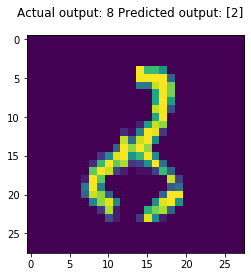

In [0]:
import numpy as np
import matplotlib.pyplot as plt

with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count==25:
                  break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " Predicted output: " + str(predx[i]))
                #fig.savefig(str(count)+".jpg")
                #files.download(str(count)+".jpg")
                count = count+1


In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.001)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,'L2')
    # scheduler.step()
    test(model, device, test_loader,'L2')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2185290902853012 Batch_id=468 Accuracy=88.73: 100%|██████████| 469/469 [00:15<00:00, 31.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1852, Accuracy: 9609/10000 (96.09%)

EPOCH: 1


Loss=0.18313837051391602 Batch_id=468 Accuracy=96.70: 100%|██████████| 469/469 [00:15<00:00, 30.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0925, Accuracy: 9793/10000 (97.93%)

EPOCH: 2


Loss=0.13400495052337646 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0704, Accuracy: 9842/10000 (98.42%)

EPOCH: 3


Loss=0.08059365302324295 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9831/10000 (98.31%)

EPOCH: 4


Loss=0.10679999738931656 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0767, Accuracy: 9789/10000 (97.89%)

EPOCH: 5


Loss=0.10750880092382431 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:15<00:00, 36.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0631, Accuracy: 9837/10000 (98.37%)

EPOCH: 6


Loss=0.1553650200366974 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9865/10000 (98.65%)

EPOCH: 7


Loss=0.0645749494433403 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 9867/10000 (98.67%)

EPOCH: 8


Loss=0.030680818483233452 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9881/10000 (98.81%)

EPOCH: 9


Loss=0.07709517329931259 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9840/10000 (98.40%)

EPOCH: 10


Loss=0.1542433798313141 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9892/10000 (98.92%)

EPOCH: 11


Loss=0.12529586255550385 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9889/10000 (98.89%)

EPOCH: 12


Loss=0.06351158767938614 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9895/10000 (98.95%)

EPOCH: 13


Loss=0.09941550344228745 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9906/10000 (99.06%)

EPOCH: 14


Loss=0.024647578597068787 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9904/10000 (99.04%)

EPOCH: 15


Loss=0.11632200330495834 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9878/10000 (98.78%)

EPOCH: 16


Loss=0.04451199993491173 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9889/10000 (98.89%)

EPOCH: 17


Loss=0.1032184362411499 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9902/10000 (99.02%)

EPOCH: 18


Loss=0.04770751670002937 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 35.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9899/10000 (98.99%)

EPOCH: 19


Loss=0.15139533579349518 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9893/10000 (98.93%)

EPOCH: 20


Loss=0.0475592315196991 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9920/10000 (99.20%)

EPOCH: 21


Loss=0.10390873998403549 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9915/10000 (99.15%)

EPOCH: 22


Loss=0.12396534532308578 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0687, Accuracy: 9820/10000 (98.20%)

EPOCH: 23


Loss=0.027201151475310326 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9914/10000 (99.14%)

EPOCH: 24


Loss=0.0605999119579792 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 30.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9898/10000 (98.98%)

EPOCH: 25


Loss=0.09514971822500229 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9882/10000 (98.82%)

EPOCH: 26


Loss=0.03993929550051689 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9907/10000 (99.07%)

EPOCH: 27


Loss=0.064045749604702 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9878/10000 (98.78%)

EPOCH: 28


Loss=0.1123645082116127 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9906/10000 (99.06%)

EPOCH: 29


Loss=0.04312904179096222 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9896/10000 (98.96%)

EPOCH: 30


Loss=0.06517352908849716 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9914/10000 (99.14%)

EPOCH: 31


Loss=0.09936579316854477 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9892/10000 (98.92%)

EPOCH: 32


Loss=0.11089857667684555 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9888/10000 (98.88%)

EPOCH: 33


Loss=0.05893212556838989 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9912/10000 (99.12%)

EPOCH: 34


Loss=0.0891914963722229 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 30.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9867/10000 (98.67%)

EPOCH: 35


Loss=0.04045357555150986 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9904/10000 (99.04%)

EPOCH: 36


Loss=0.10351983457803726 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9914/10000 (99.14%)

EPOCH: 37


Loss=0.07304888218641281 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:15<00:00, 30.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9894/10000 (98.94%)

EPOCH: 38


Loss=0.08457737416028976 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9912/10000 (99.12%)

EPOCH: 39


Loss=0.03983251377940178 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:15<00:00, 39.37it/s]



Test set: Average loss: 0.0607, Accuracy: 9845/10000 (98.45%)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


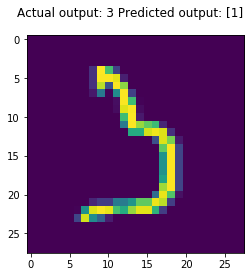

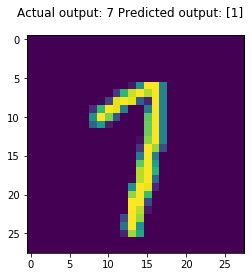

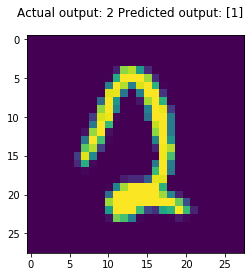

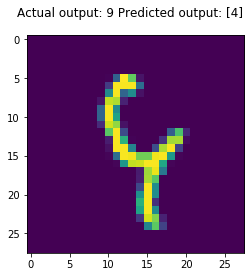

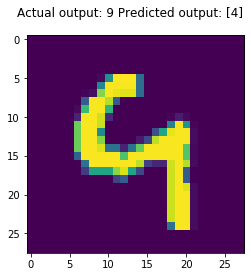

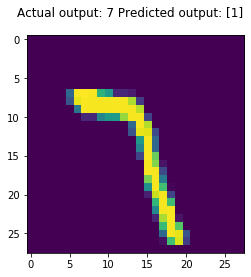

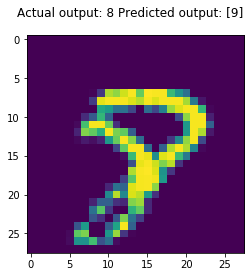

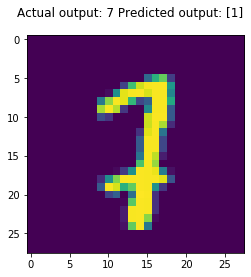

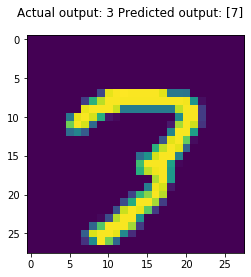

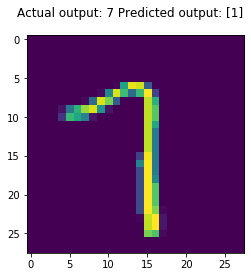

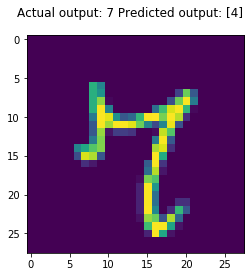

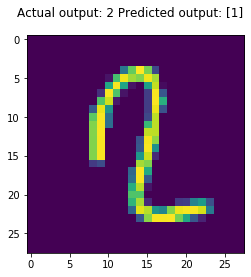

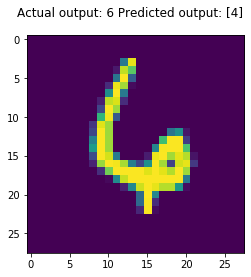

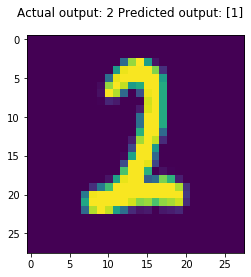

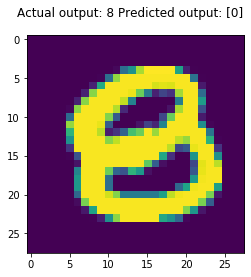

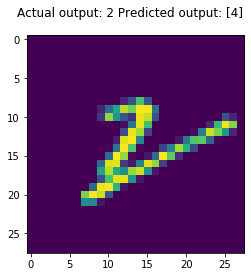

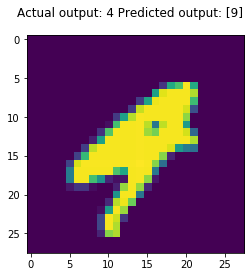

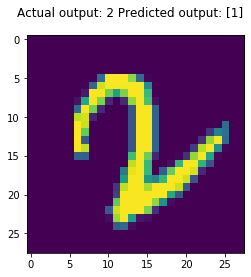

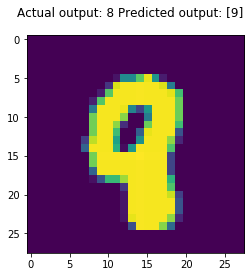

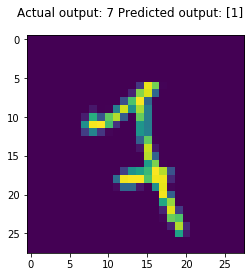

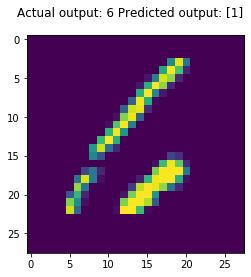

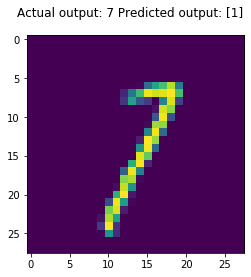

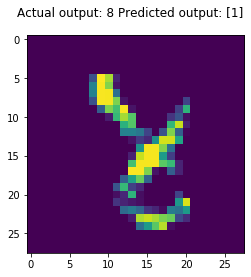

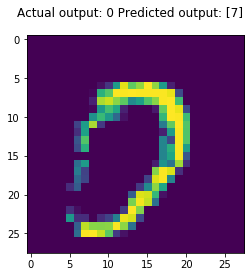

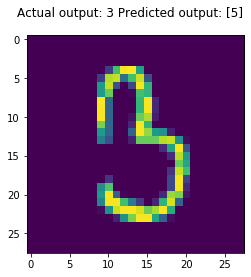

In [0]:
import numpy as np
import matplotlib.pyplot as plt

with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count==25:
                  break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " Predicted output: " + str(predx[i]))
                #fig.savefig(str(count)+".jpg")
                #files.download(str(count)+".jpg")
                count = count+1


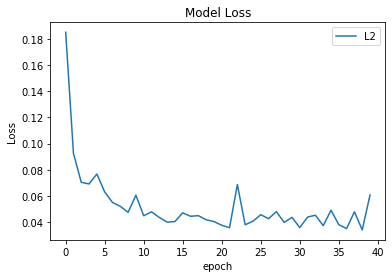

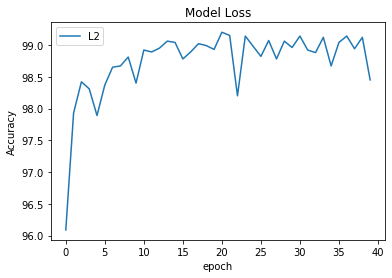

In [0]:
plt.plot(test_losses_L2)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['L2'],loc='best')
plt.show()



plt.plot(test_acc_L2)
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['L2'],loc='best')
plt.show()

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0,dampening=0, weight_decay=0.0005,nesterov=False)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS =40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,'L1_L2')
    # scheduler.step()
    test(model, device, test_loader,'L1_L2')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=1.2432186603546143 Batch_id=468 Accuracy=69.56: 100%|██████████| 469/469 [00:17<00:00, 27.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9967, Accuracy: 8244/10000 (82.44%)

EPOCH: 1


Loss=0.8950045108795166 Batch_id=468 Accuracy=89.94: 100%|██████████| 469/469 [00:16<00:00, 28.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5060, Accuracy: 9335/10000 (93.35%)

EPOCH: 2


Loss=0.6576111912727356 Batch_id=468 Accuracy=93.13: 100%|██████████| 469/469 [00:16<00:00, 27.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3077, Accuracy: 9551/10000 (95.51%)

EPOCH: 3


Loss=0.6067315340042114 Batch_id=468 Accuracy=94.56: 100%|██████████| 469/469 [00:16<00:00, 27.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2345, Accuracy: 9646/10000 (96.46%)

EPOCH: 4


Loss=0.47892260551452637 Batch_id=468 Accuracy=95.35: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1833, Accuracy: 9692/10000 (96.92%)

EPOCH: 5


Loss=0.4150514602661133 Batch_id=468 Accuracy=96.03: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1648, Accuracy: 9690/10000 (96.90%)

EPOCH: 6


Loss=0.35549408197402954 Batch_id=468 Accuracy=96.38: 100%|██████████| 469/469 [00:16<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1484, Accuracy: 9707/10000 (97.07%)

EPOCH: 7


Loss=0.40539804100990295 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1381, Accuracy: 9716/10000 (97.16%)

EPOCH: 8


Loss=0.35474950075149536 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1291, Accuracy: 9727/10000 (97.27%)

EPOCH: 9


Loss=0.34186914563179016 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1181, Accuracy: 9749/10000 (97.49%)

EPOCH: 10


Loss=0.3336412012577057 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:16<00:00, 28.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1092, Accuracy: 9757/10000 (97.57%)

EPOCH: 11


Loss=0.3064861297607422 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1312, Accuracy: 9693/10000 (96.93%)

EPOCH: 12


Loss=0.32203567028045654 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1140, Accuracy: 9722/10000 (97.22%)

EPOCH: 13


Loss=0.35301586985588074 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1425, Accuracy: 9638/10000 (96.38%)

EPOCH: 14


Loss=0.3067721128463745 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0829, Accuracy: 9800/10000 (98.00%)

EPOCH: 15


Loss=0.24885308742523193 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0932, Accuracy: 9781/10000 (97.81%)

EPOCH: 16


Loss=0.30673742294311523 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:16<00:00, 27.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1026, Accuracy: 9737/10000 (97.37%)

EPOCH: 17


Loss=0.25827282667160034 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:16<00:00, 28.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0798, Accuracy: 9802/10000 (98.02%)

EPOCH: 18


Loss=0.17830000817775726 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0833, Accuracy: 9801/10000 (98.01%)

EPOCH: 19


Loss=0.21993696689605713 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0811, Accuracy: 9812/10000 (98.12%)

EPOCH: 20


Loss=0.27441179752349854 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0855, Accuracy: 9783/10000 (97.83%)

EPOCH: 21


Loss=0.21824899315834045 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0642, Accuracy: 9849/10000 (98.49%)

EPOCH: 22


Loss=0.1454213261604309 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:16<00:00, 34.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0776, Accuracy: 9798/10000 (97.98%)

EPOCH: 23


Loss=0.20927362143993378 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9880/10000 (98.80%)

EPOCH: 24


Loss=0.26043787598609924 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0776, Accuracy: 9795/10000 (97.95%)

EPOCH: 25


Loss=0.18843083083629608 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9858/10000 (98.58%)

EPOCH: 26


Loss=0.1908031702041626 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9857/10000 (98.57%)

EPOCH: 27


Loss=0.18413467705249786 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9862/10000 (98.62%)

EPOCH: 28


Loss=0.16769877076148987 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:16<00:00, 34.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9838/10000 (98.38%)

EPOCH: 29


Loss=0.19866497814655304 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9884/10000 (98.84%)

EPOCH: 30


Loss=0.1693604290485382 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:16<00:00, 28.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0607, Accuracy: 9845/10000 (98.45%)

EPOCH: 31


Loss=0.175083190202713 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9831/10000 (98.31%)

EPOCH: 32


Loss=0.15823540091514587 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0612, Accuracy: 9834/10000 (98.34%)

EPOCH: 33


Loss=0.19253145158290863 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:16<00:00, 28.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0556, Accuracy: 9857/10000 (98.57%)

EPOCH: 34


Loss=0.14779521524906158 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9877/10000 (98.77%)

EPOCH: 35


Loss=0.18291276693344116 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9893/10000 (98.93%)

EPOCH: 36


Loss=0.16239547729492188 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9866/10000 (98.66%)

EPOCH: 37


Loss=0.21306654810905457 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9863/10000 (98.63%)

EPOCH: 38


Loss=0.23061569035053253 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:16<00:00, 28.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9859/10000 (98.59%)

EPOCH: 39


Loss=0.16640982031822205 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]



Test set: Average loss: 0.0750, Accuracy: 9783/10000 (97.83%)



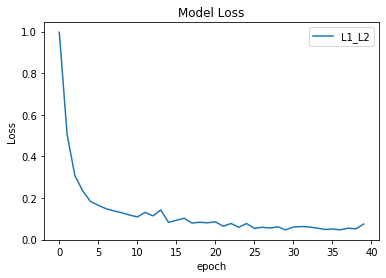

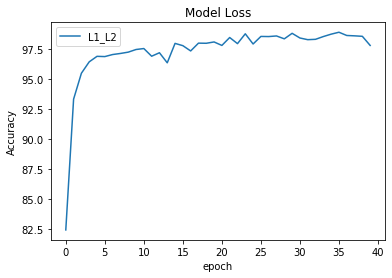

In [0]:
plt.plot(test_losses_L1_L2)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['L1_L2'],loc='best')
plt.show()

plt.plot(test_acc_L1_L2)
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['L1_L2'],loc='best')
plt.show()

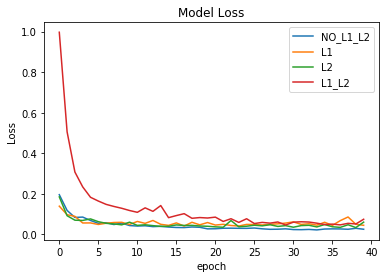

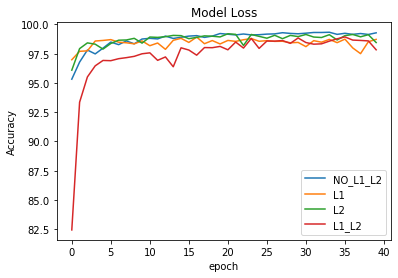

In [0]:
plt.plot(test_losses)
plt.plot(test_losses_L1)
plt.plot(test_losses_L2)
plt.plot(test_losses_L1_L2)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['NO_L1_L2','L1','L2','L1_L2'],loc='best')
plt.show()

plt.plot(test_acc)
plt.plot(test_acc_L1)
plt.plot(test_acc_L2)
plt.plot(test_acc_L1_L2)

plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['NO_L1_L2','L1','L2','L1_L2'],loc='best')

plt.show()